## Inverse Problems in Imaging
In this notebook we'll move on from denoising and begin to tackle inverse problems. Our notation will be as follows: we want to find $f$, given $y$ and $A$, where $y = A f$. We may also add noise so that we have $y = A f + \epsilon$. Here, $A$ is a linear operator (can be expressed as a matrix multiply). If $A = I$, then this is exactly the denoising setting we've been using for now.

So our task is to minimize this term: 
$$ || A f - y ||_2^2$$
for $f$. If we're lucky, we can use the **normal equations**:
$$A^\top A f = A^\top y$$
to get the right solution. Sometimes, as we'll demonstrate, this approach is not enough. 

In this module, we'll first start off by demo-ing our forward operators under consideration, we'll attempt to solve them with direct inversion. Later we'll deal with sparsity and other forms of regularization.

As usual, let's start off by importing our favorite test image.

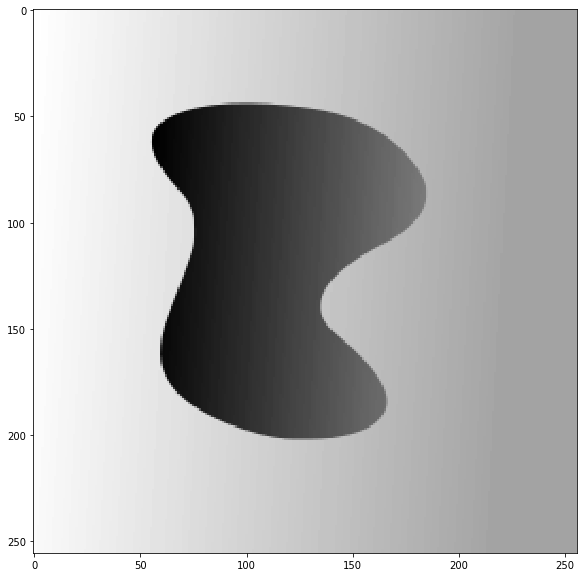

In [1]:
import imageio, os, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
cwd = os.getcwd()
image_folder = cwd + "/images/"

example_image_path = image_folder + "blob.png"
test_image = imageio.imread(example_image_path, pilmode='L')
fig = plt.figure()
plt.imshow(test_image, cmap='gray')
plt.show()

#### Deconvolution (deblurring)
The first forward model we'll deal with is a simple convolution. In our case, we'll stick with a simple Gaussian convolution. Remember the Gaussian filter from the first denoising module? We'll be using it here.

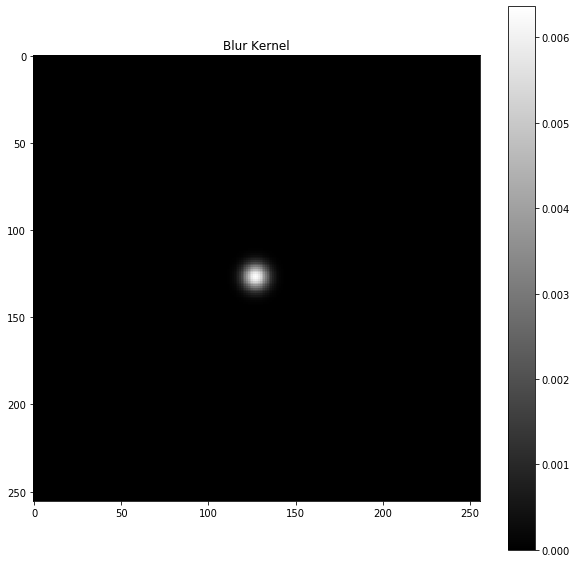

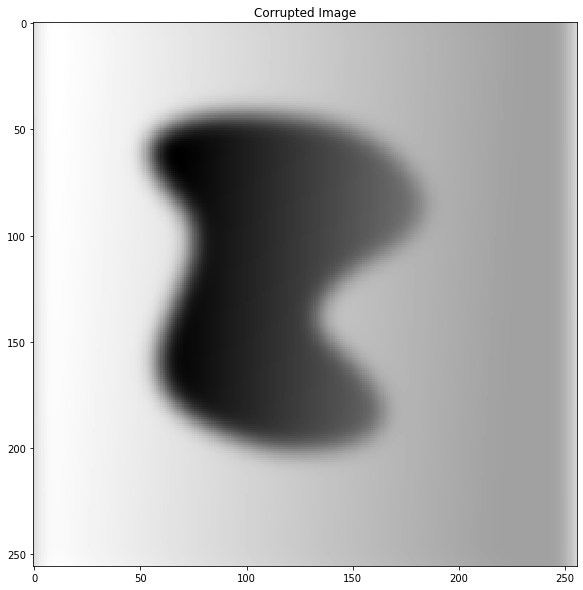

In [11]:
from scipy.signal import convolve
import corruption_models
def gaussian_filter_coeffs(size, sigma):
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g / np.sum(g[:])

def uniform_filter_coeffs(size, width):
    g = np.zeros((size,size))
    lower_bound = int(size//2 - width//2)
    upper_bound = int(size//2 + width//2)
    g[lower_bound:upper_bound, lower_bound:upper_bound] = 1
    return g / np.sum(g[:])

image_dimensions = np.shape(test_image)[0]
kernel_sigma = 5
noise_sigma = np.sqrt(0.000001)
blur_kernel = gaussian_filter_coeffs(image_dimensions, kernel_sigma)
# blur_kernel = uniform_filter_coeffs(image_dimensions, kernel_sigma)

corrupted_image = corruption_models.blur_and_add_noise(test_image, blur_kernel, noise_sigma)
# blurred_image = corruption_models.gaussian_blur(test_image, blur_kernel)

fig = plt.figure()
plt.imshow(blur_kernel, cmap='gray'); plt.title("Blur Kernel"); plt.colorbar()
fig = plt.figure()
plt.imshow(corrupted_image, cmap='gray'); plt.title("Corrupted Image")
plt.show()

We already demonstrated that we can apply the blur in Fourier space - let's do the deconvolution there as well!

We'll first demonstrate straightforward inversion in Fourier space, just ignoring the noise. 

We'll first demonstrate Wiener filtering, which is in the L2 sense the optimal reconstruction. Note that the reconstruction has some ringing near the edges - we'll want to get rid of those with some regularization in the next module.

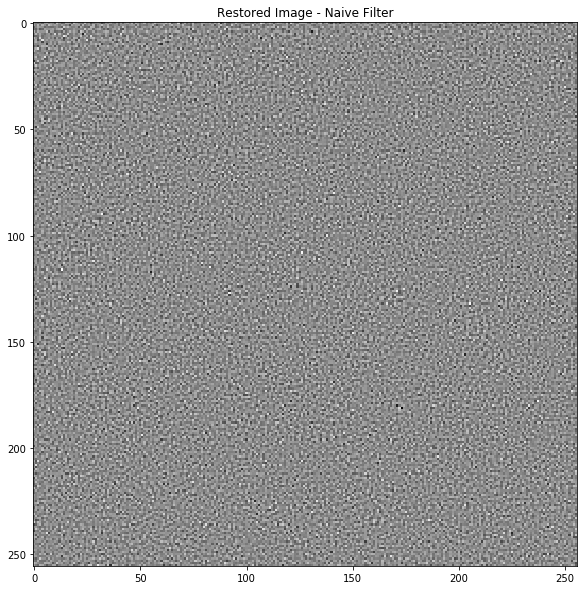

In [12]:
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift

def naive_linear_inverse(input_data, convolution_kernel):
    filter_fft = fft2(ifftshift(convolution_kernel))
    fourier_data = fft2(input_data)
    naive_filter = filter_fft
    return np.real(ifft2(fourier_data / (naive_filter + 1e-13)))

# test_data = wiener_filter(input_data=corrupted_image, corruption_kernel=blur_kernel, noise_sigma=noise_sigma)
naive_reconstruction = naive_linear_inverse(input_data=corrupted_image, convolution_kernel=blur_kernel)
fig = plt.figure()
plt.imshow(naive_reconstruction, cmap='gray'); plt.title("Restored Image - Naive Filter")
plt.show()

This reconstruction is obviously suboptimal! What happened here?

Let's examine the fft of the blur kernel we used.

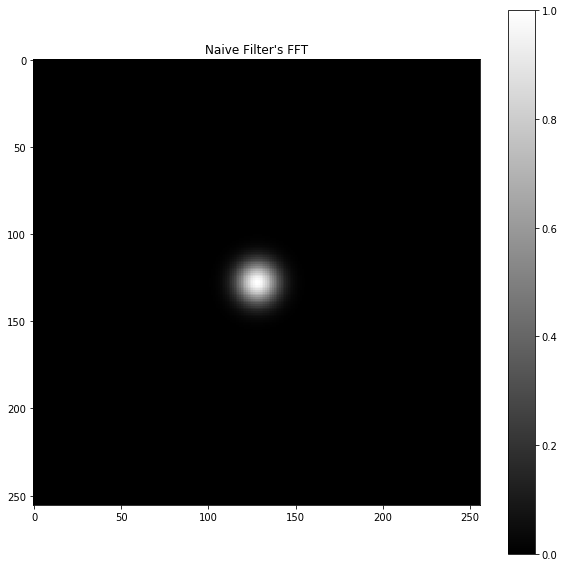

In [13]:
filter_fft = fftshift(fft2(ifftshift(blur_kernel)))

fig = plt.figure()
plt.imshow(np.abs(filter_fft), cmap='gray'); plt.title("Naive Filter's FFT"); plt.colorbar()
plt.show()

This filter is ill-conditioned. Note the large portions of the filter that have 0 magnitude - if we divide by these we're going to get garbage at best. In addition, even adding a small constant to the areas with 0 magnitude won't help, because we're going to be preferentially amplifying noise in those regions.

For ill-conditioned problems like these, naive regularization might partially work, but you're almost certainly going to blow up the noise more than the signal you're interested in. Let's look at a regularization scheme we can use to attenuate the noise a bit.

### Tikhonov Regularization
Tikhonov, or ridge, regression consists of minimizing the following expression:
$$ || A \ f - y ||_2^2 + \frac{\lambda}{2} \ ||f||_2^2.$$
Like before, we can solve the normal equations to get the following optimality condition:
$$(A^\top A + \lambda I) \ f = A^\top y$$

Unfortunately, actually solving the above equation analytically is very computationally costly. But in the deblurring case, we're able to add in a regularization term in Fourier space. In this case, the Tikhonov norm penalty has an impulse response that acts like a discrete Laplacian operator.

PSNR: 32.06728335938987


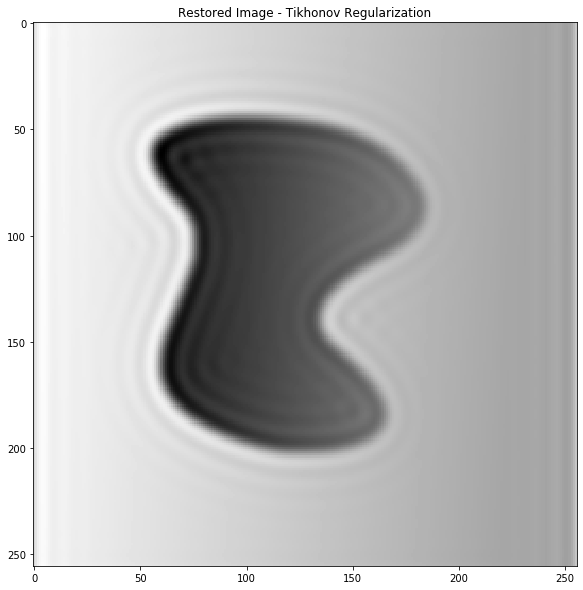

In [23]:
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift

def tikhonov_fft(size):
    output_filter = np.zeros((size, size))
    laplacian = np.asarray([[1,3,1],[3,-20,3],[1,3,1]])
    output_filter[:3,:3] = laplacian
    output_filter = np.roll(output_filter,(-1,-1))
    return fft2(output_filter)
    

def tikhonov_filter(input_data, corruption_kernel, noise_sigma):
    size = np.shape(input_data)[0]
    S = tikhonov_fft(size)
    filter_shifted = fft2(fftshift(corruption_kernel))
    fourier_data = fft2(input_data)
    
    weiner_filter = np.conj(filter_shifted) / (np.square(np.abs(filter_shifted)) + noise_sigma**2*np.square(np.abs(S)) + 1e-13)
    return np.real(ifft2(fourier_data * weiner_filter))

tikhonov_reconstruction = tikhonov_filter(input_data=corrupted_image, corruption_kernel=blur_kernel, noise_sigma=noise_sigma)

print("PSNR: " + str(utils.calculate_psnr(tikhonov_reconstruction, test_image)))

fig = plt.figure()
plt.imshow(tikhonov_reconstruction, cmap='gray'); plt.title("Restored Image - Tikhonov Regularization")
plt.show()

This is much better, but we still see some evidence of ringing. Let's try one more analytical inversion method before we move on to iterative methods.

### Wiener Filtering
Wiener filtering is optimal in the L2 sense in terms of analytical inverses for linear forward problems with Gaussian noise. The filter is given in Fourier space as:

$$W(\omega_1, \omega_2) = \frac{H(\omega_1, \omega_2)^* \ S(\omega_1, \omega_2)}{|H(\omega_1, \omega_2)|^2 \ S(\omega_1, \omega_2) + \sigma^2}$$

Where $H$ is the frequency response of our corruption model, $S$ is the power spectrum of our input, and $\sigma$ is the standard deviation of our Gaussian noise. If the noise has a different power spectrum, we can incorporate that as well, by changing $\sigma^2$ from being a constant to being the power spectrum of the noise.

In code, this will look like:

PSNR: 33.52368061113805


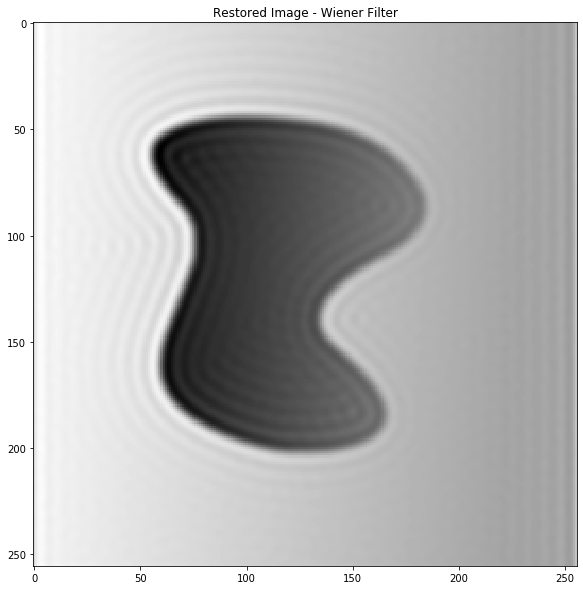

In [26]:
def psd_estimate(size):
    # The power spectrum of natural images seems to decay like 1 / F^\alpha, where
    # \alpha is around 2. What's the best alpha here? A better psd estimate might be better for reconstruction...
    alpha = 2.0
    x, y = np.mgrid[-size//2 + 1:size//2+1, -size//2 + 1:size//2+1]
    x = np.array(x, dtype=np.complex); y = np.array(y, dtype=np.complex)
    g = 1. / ((x*2./size)**alpha + (y*2./size)**alpha + 1e-13)
    return g

def wiener_filter(input_data, corruption_kernel, noise_sigma):
    size = np.shape(input_data)[0]
    S = fftshift(psd_estimate(size))
    filter_shifted = fft2(fftshift(corruption_kernel))
    fourier_data = fft2(input_data)
    weiner_filter = np.conj(filter_shifted)*S / (np.square(np.abs(filter_shifted))*S + noise_sigma**2 + 1e-13)
    return np.real(ifft2(fourier_data * weiner_filter))


wiener_data = wiener_filter(input_data=corrupted_image, corruption_kernel=blur_kernel, noise_sigma=noise_sigma)

print("PSNR: " + str(utils.calculate_psnr(wiener_data, test_image)))

fig = plt.figure()
plt.imshow(wiener_data, cmap='gray'); plt.title("Restored Image - Wiener Filter")
plt.show()

This is a better reconstruction in terms of PSNR, but still has ringing. Later we'll try to find methods that can help deal with that.

### Inpainting
Before we get to other inverse problem solutions, let's take a quick glance at our inpainting problem, the other forward model we'll be using later. Briefly, our forward model will zero out pixels at random in our image. The corruption_models.py module can be used to generate such a random mask, as well as apply it to an image:

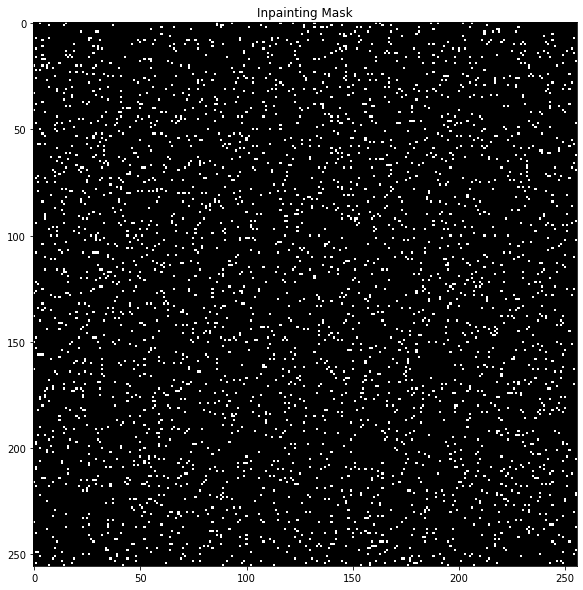

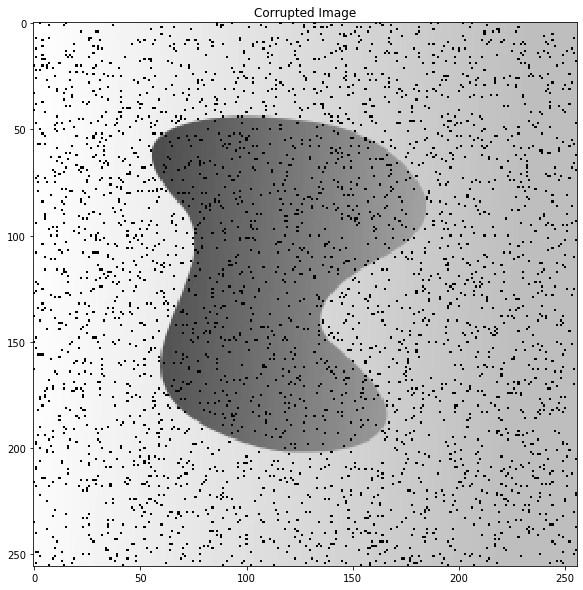

In [7]:
pixel_deletion_mask = corruption_models.get_inpainting_map(np.shape(test_image), p=0.95)
inpainting_corrupted_image = corruption_models.apply_inpainting_map(test_image, pixel_deletion_mask)

fig = plt.figure()
plt.imshow(1.0*pixel_deletion_mask, cmap='gray'); plt.title("Inpainting Mask")
fig = plt.figure()
plt.imshow(inpainting_corrupted_image, cmap='gray'); plt.title("Corrupted Image")
plt.show()

We won't be able to use a standard linear inverse, and Tikhonov regularization will just shrink the nonzero elements of the image. We'll explore using iterative approaches in the next workbook, but if you happen across something like this in the future, skimage has some standard ways to deal with inpainting:

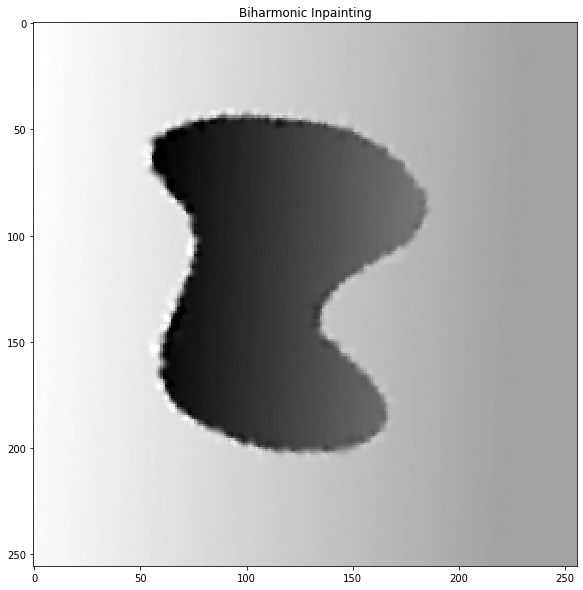

In [10]:
from skimage import restoration
import warnings
# Please turn p up higher than 0.2. inpaint_biharmonic is very, very slow.
pixel_deletion_mask = corruption_models.get_inpainting_map(np.shape(test_image), p=0.2)
inpainting_corrupted_image = corruption_models.apply_inpainting_map(test_image, pixel_deletion_mask)

# This doesn't actually do anything to the image, but the inpaint_biharmonic
# function uses some methods that scipy.sparse gets really upset about. 
# Note that this will take a while!
warnings.filterwarnings("ignore", category=FutureWarning)
inpainting_restored = restoration.inpaint_biharmonic(inpainting_corrupted_image, pixel_deletion_mask)
warnings.filterwarnings("default", category=FutureWarning)

fig = plt.figure()
plt.imshow(inpainting_restored, cmap='gray'); plt.title("Biharmonic Inpainting")
plt.show()